## Initial Cleaning Steps

I read this data in as string because it was difficult to do so otherwise

In [52]:
# import data csv
import pandas as pd
df = pd.read_csv("loan.csv", delimiter = ",",index_col=False, dtype = "str")

In [53]:
import warnings
warnings.filterwarnings("ignore")

In [54]:
#check shape to ensure data transferred as expected
df.shape

(2260668, 145)

In [55]:
# remove any columns that have a huge no-value count 
df.dropna(thresh = 1500000, axis = 1, inplace = True)

In [59]:
df.shape

(1303607, 87)

In [57]:
# check dependent variable counts
print(df["loan_status"].value_counts())

Fully Paid                                             1041952
Current                                                 919695
Charged Off                                             261655
Late (31-120 days)                                       21897
In Grace Period                                           8952
Late (16-30 days)                                         3737
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     31
Name: loan_status, dtype: int64


In [60]:
# remove unwanted categories from dependent variable
df = df[df.loan_status != "Current"]
df = df[df.loan_status != "Late (31-120 days)"]
df = df[df.loan_status != "Late (16-30 days)"]
df = df[df.loan_status != "In Grace Period"]
df = df[df.loan_status != "Default"]
df = df[df.loan_status != "Does not meet the credit policy. Status:Fully Paid"]
df = df[df.loan_status != "Does not meet the credit policy. Status:Charged Off"]


In [61]:
df.shape

(1303607, 87)

I removed certain columns from the analysis because this was information a lender would not have while giving a loan and so it was giving the model very high predictive powers. These columns were decided upon after I read up the description of each variable and decided upon which information would not be available at the time of lending. I also consulted the company website to study their model and make better judgements in choosing these variables.

In [62]:
# Remove columns that represent information not necessary or not information available to lender while giving the loan
df = df.drop(['total_pymnt_inv','total_pymnt','debt_settlement_flag','out_prncp','last_pymnt_d','last_pymnt_amnt','out_prncp_inv','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee','total_rec_prncp','total_rev_hi_lim','total_rec_int'],axis = 1)

In [63]:
df.shape

(1303607, 74)

In [13]:
pd.set_option('display.max_columns', None)

In [64]:
df_colnans = df.isna().sum()
df_colnans.value_counts()

0         29
67527     15
47281      4
67528      3
1          2
55841      2
56         2
67548      1
54         1
115570     1
82579      1
104295     1
39         1
810        1
67681      1
312        1
169549     1
697        1
75454      1
61047      1
60639      1
59741      1
61386      1
15426      1
dtype: int64

In [65]:
nans = pd. DataFrame(df_colnans)
nans.columns = nans.columns.astype(str)


In [66]:
nans.head()


,0
loan_amnt,0
funded_amnt,0
funded_amnt_inv,0
term,0
int_rate,0


In [67]:
for col in nans.columns:
    print(col)

0


In [68]:
nans.rename(columns = {'0':'NAs'}, inplace = True)

In [76]:
nans.shape

(45, 1)

In [70]:
nans = nans[nans.NAs != 0]

In [75]:
nans.sort_values('NAs',ascending = False)

,NAs
mths_since_recent_inq,169549
num_tl_120dpd_2m,115570
mo_sin_old_il_acct,104295
emp_title,82579
emp_length,75454
pct_tl_nvr_dlq,67681
avg_cur_bal,67548
mo_sin_rcnt_rev_tl_op,67528
mo_sin_old_rev_tl_op,67528
num_rev_accts,67528


In [82]:
df.isna().sum().sum()

0

In [65]:
# now remove all rows with any no-value cells in them
df = df.dropna(axis = 0, how = 'any')

In [66]:
df.shape

(956732, 74)

In [67]:
#export to csv
df.to_csv('Data_no_NAN.csv')

Exported this to CSV as loading the full data again and again was becoming cumbersome. After this, I only work with the new CSV.

## Loading the Data


In [4]:
# Read in the cleaned csv
import pandas as pd
final = pd.read_csv('Data_no_NAN.csv')

pd.set_option('display.max_columns', None)

In [5]:
# There is only instance of it in the data and it causes us dimension problems once we run get.dummies so removing it up-front
final = final[final.purpose != 'educational']

In [6]:
# check shape
final.shape

(956731, 75)

## Feature Selection Process

In [6]:
# set the data up to do the train-test split to calculate mutual info scores
from sklearn.model_selection import train_test_split


df_y = final['loan_status']
df_x = final.drop(['loan_status'],axis = 1)

X = df_x
y = df_y

In [7]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y)

In [8]:
# take a look at the mutual info scores to select which features will be part of the model
from sklearn.metrics.cluster import adjusted_mutual_info_score
from sklearn.metrics import mutual_info_score
import matplotlib.pyplot as plt

adjusted_mutual_info_scores = []

for feature in X_train.columns:
    # Calculate the mutual info score
    m_info = adjusted_mutual_info_score(X_train[feature], y_train)
    # Append it to our list
    adjusted_mutual_info_scores.append(m_info)

plt.figure(figsize = (16,16))
plt.bar(X_train.columns, adjusted_mutual_info_scores)
plt.ylabel('Mutual info shared with Target')
plt.xticks(rotation=90)
plt.plot()

/Users/farhanahmed/anaconda3/lib/python3.7/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


[]

In [9]:
#Select the top 35 features in terms of MIS
MIS = pd.DataFrame({'Features' : X_train.columns, 'Info Scores' : adjusted_mutual_info_scores}, dtype = float)
MIS = MIS.sort_values('Info Scores', ascending = False)
MIS_55 = pd.DataFrame(MIS.head(55))
MIS_55 = MIS_55.set_index('Features')


In [10]:
cols = MIS_55.index

In [11]:
cols.shape

(55,)

In [12]:
final = final[cols]

In [13]:
num_cols = final._get_numeric_data().columns
num_cols.shape


(40,)

In [14]:
#Finding the categorical columns in the top 35
cat_cols = list(set(cols) - set(num_cols))
cat_cols

['purpose',
 'issue_d',
 'emp_title',
 'verification_status',
 'last_credit_pull_d',
 'addr_state',
 'application_type',
 'sub_grade',
 'grade',
 'earliest_cr_line',
 'home_ownership',
 'emp_length',
 'zip_code',
 'title',
 'term']

In [15]:
final.shape

(956731, 55)

In [16]:
for i in cat_cols:
    print(i, final[i].unique())

purpose ['debt_consolidation' 'credit_card' 'other' 'house' 'car'
 'home_improvement' 'moving' 'medical' 'major_purchase' 'vacation'
 'small_business' 'renewable_energy' 'wedding']
issue_d ['Dec-2018' 'Nov-2018' 'Oct-2018' 'Sep-2018' 'Aug-2018' 'Jul-2018'
 'Jun-2018' 'May-2018' 'Apr-2018' 'Mar-2018' 'Feb-2018' 'Jan-2018'
 'Sep-2016' 'Aug-2016' 'Jul-2016' 'Jun-2016' 'May-2016' 'Apr-2016'
 'Mar-2016' 'Feb-2016' 'Jan-2016' 'Dec-2016' 'Nov-2016' 'Oct-2016'
 'Dec-2015' 'Nov-2015' 'Oct-2015' 'Sep-2015' 'Aug-2015' 'Jul-2015'
 'Jun-2015' 'May-2015' 'Apr-2015' 'Mar-2015' 'Feb-2015' 'Jan-2015'
 'Mar-2017' 'Feb-2017' 'Jan-2017' 'Sep-2017' 'Aug-2017' 'Jul-2017'
 'Jun-2017' 'May-2017' 'Apr-2017' 'Dec-2013' 'Nov-2013' 'Oct-2013'
 'Sep-2013' 'Aug-2013' 'Jul-2013' 'Jun-2013' 'May-2013' 'Apr-2013'
 'Mar-2013' 'Feb-2013' 'Jan-2013' 'Dec-2012' 'Nov-2012' 'Oct-2012'
 'Sep-2012' 'Aug-2012' 'Dec-2014' 'Nov-2014' 'Oct-2014' 'Sep-2014'
 'Aug-2014' 'Jul-2014' 'Jun-2014' 'May-2014' 'Apr-2014' 'Mar-2014'
 'Feb-2

In [43]:
final['purpose'].value_counts()

debt_consolidation    565023
credit_card           208787
home_improvement       63071
other                  52116
major_purchase         19687
medical                10523
small_business          9428
car                     9127
moving                  6373
vacation                6207
house                   5094
wedding                  697
renewable_energy         598
Name: purpose, dtype: int64

In [17]:
# remove un-manageable categorical data points
final.drop(columns = ['title','earliest_cr_line','last_credit_pull_d','issue_d','zip_code','emp_title','addr_state'], inplace = True)
final.shape


(956731, 48)

In [18]:
final.columns

Index(['term', 'grade', 'sub_grade', 'int_rate', 'verification_status',
       'installment', 'home_ownership', 'mort_acc', 'acc_open_past_24mths',
       'num_tl_op_past_12m', 'loan_amnt', 'funded_amnt', 'inq_last_6mths',
       'funded_amnt_inv', 'purpose', 'percent_bc_gt_75', 'num_rev_tl_bal_gt_0',
       'num_actv_rev_tl', 'dti', 'pub_rec', 'mo_sin_rcnt_tl',
       'mths_since_recent_inq', 'mo_sin_rcnt_rev_tl_op',
       'pub_rec_bankruptcies', 'annual_inc', 'total_bc_limit',
       'mo_sin_old_rev_tl_op', 'mths_since_recent_bc', 'num_actv_bc_tl',
       'bc_util', 'num_accts_ever_120_pd', 'revol_util', 'tot_coll_amt',
       'delinq_2yrs', 'delinq_amnt', 'collections_12_mths_ex_med', 'tax_liens',
       'num_op_rev_tl', 'num_sats', 'open_acc', 'num_tl_90g_dpd_24m',
       'application_type', 'mo_sin_old_il_acct', 'pct_tl_nvr_dlq', 'num_bc_tl',
       'emp_length', 'total_il_high_credit_limit', 'total_acc'],
      dtype='object')

In [19]:
MIS.shape


(74, 2)

In [9]:
# Select the columns with highest mutual information scores
#col_list =['loan_status','anjnual_inc','loan_amnt','term','pub_rec','chargeoff_within_12_mths', 'int_rate', 'installment','grade', 'home_ownership', 'verification_status','purpose','dti','inq_last_6mths','acc_open_past_24mths','mort_acc','num_actv_rev_tl','num_rev_tl_bal_gt_0','num_tl_op_past_12m','percent_bc_gt_75','tot_hi_cred_lim','total_il_high_credit_limit']

In [80]:
# include only the columns selected
#final = final[num_cols]


Since assigning positive label to one class was still leading to confusion, I decided to convert the dependent variable to a binary 0 and 1 for the two classes.

In [20]:
df_y.values

array(['Fully Paid', 'Fully Paid', 'Fully Paid', ..., 'Fully Paid',
       'Fully Paid', 'Fully Paid'], dtype=object)

In [21]:
import numpy as np
# convert y variable to 0/1 binary
df_y = np.where(df_y.values=='Charged Off',1,0)

In [22]:
# check final shape of data
final.shape



(956731, 48)

In [23]:
print(df_y.shape)
print(df_x.shape)
print(df_y.shape)


(956731,)
(956731, 74)
(956731,)


In [24]:
# re-do after changes
from sklearn.model_selection import train_test_split


df_x = final

X = df_x
y = df_y

In [25]:
# do the train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, stratify = y)

In [26]:
# One-hot encode categorical variables
X_train = pd.get_dummies(X_train)
X_test = pd.get_dummies(X_test)



In [27]:
# Take a look at the data
X_test.head()



,int_rate,installment,mort_acc,acc_open_past_24mths,num_tl_op_past_12m,loan_amnt,funded_amnt,inq_last_6mths,funded_amnt_inv,percent_bc_gt_75,num_rev_tl_bal_gt_0,num_actv_rev_tl,dti,pub_rec,mo_sin_rcnt_tl,mths_since_recent_inq,mo_sin_rcnt_rev_tl_op,pub_rec_bankruptcies,annual_inc,total_bc_limit,mo_sin_old_rev_tl_op,mths_since_recent_bc,num_actv_bc_tl,bc_util,num_accts_ever_120_pd,revol_util,tot_coll_amt,delinq_2yrs,delinq_amnt,collections_12_mths_ex_med,tax_liens,num_op_rev_tl,num_sats,open_acc,num_tl_90g_dpd_24m,mo_sin_old_il_acct,pct_tl_nvr_dlq,num_bc_tl,total_il_high_credit_limit,total_acc,term_ 36 months,term_ 60 months,grade_A,grade_B,grade_C,grade_D,grade_E,grade_F,grade_G,sub_grade_A1,sub_grade_A2,sub_grade_A3,sub_grade_A4,sub_grade_A5,sub_grade_B1,sub_grade_B2,sub_grade_B3,sub_grade_B4,sub_grade_B5,sub_grade_C1,sub_grade_C2,sub_grade_C3,sub_grade_C4,sub_grade_C5,sub_grade_D1,sub_grade_D2,sub_grade_D3,sub_grade_D4,sub_grade_D5,sub_grade_E1,sub_grade_E2,sub_grade_E3,sub_grade_E4,sub_grade_E5,sub_grade_F1,sub_grade_F2,sub_grade_F3,sub_grade_F4,sub_grade_F5,sub_grade_G1,sub_grade_G2,sub_grade_G3,sub_grade_G4,sub_grade_G5,verification_status_Not Verified,verification_status_Source Verified,verification_status_Verified,home_ownership_ANY,home_ownership_MORTGAGE,home_ownership_NONE,home_ownership_OTHER,home_ownership_OWN,home_ownership_RENT,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_renewable_energy,purpose_small_business,purpose_vacation,purpose_wedding,application_type_Individual,application_type_Joint App,emp_length_1 year,emp_length_10+ years,emp_length_2 years,emp_length_3 years,emp_length_4 years,emp_length_5 years,emp_length_6 years,emp_length_7 years,emp_length_8 years,emp_length_9 years,emp_length_< 1 year
191382,11.99,232.47,0,8,6,7000,7000,0,7000.0,9.1,9,9,14.25,0,3,7,3,0,70000.0,13000,51,3,9,34.4,0,34.4,1141,1,0,0,0,11,12,12,0,58,93.3,12,36114,15,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0
194014,8.49,378.76,0,1,1,12000,12000,0,12000.0,0.0,7,5,35.51,0,5,21,54,0,52850.0,42600,154,54,4,33.4,0,33.4,0,0,0,0,0,8,10,10,0,94,100.0,5,41750,15,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
264571,13.67,415.76,1,5,2,18000,18000,0,18000.0,75.0,5,5,12.48,0,6,7,6,0,50000.0,15500,60,6,4,67.9,0,71.2,0,0,0,0,0,5,7,7,0,196,100.0,4,11211,12,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
771094,12.99,796.18,4,4,2,35000,35000,1,35000.0,57.1,8,8,24.34,0,2,2,2,0,100000.0,44800,159,2,5,83.2,0,86.0,0,0,0,0,0,11,14,14,0,135,100.0,10,31103,24,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0
176698,9.16,248.62,0,6,2,7800,7800,0,7800.0,25.0,4,4,14.35,0,8,16,8,0,38480.0,20700,127,12,4,60.9,0,49.9,0,0,0,0,0,6,13,13,0,122,100.0,10,14715,35,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0


## Let's now scale data

In [28]:
print(X_train.shape)
print(X_test.shape)

(574038, 119)
(382693, 119)


In [131]:
XT_cols = X_train.columns
Xtt_cols = X_test.columns
ans = list(set(XT_cols) - set(Xtt_cols))
ans

['hardship_flag_Y']

In [29]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler()
# Instantiate
scaler.fit(X_train)
# Transform the data
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

/Users/farhanahmed/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/farhanahmed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  
/Users/farhanahmed/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, int64, float64 were all converted to float64 by StandardScaler.
  import sys


For evaluation purposes, we will not look at just accuracy because data imbalance means the data is already almost 80% of one class. We will try to achieve the highest possible recall so predicting as many of the charged-off class with the highest f1 score.

## Logistic Model

Let's use cross-validation to optimize our hyperparameter for the Logistic regression C. 

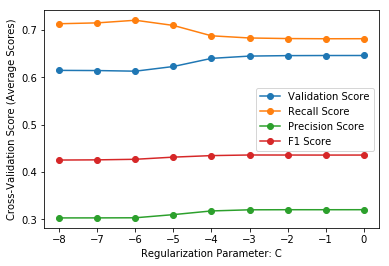

In [46]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

# Lets plot out different parameters with 5-fold cross validation
validation_score_list = []
sample_range = [.00000001,.0000001,.000001,.00001,.0001,0.001,0.01,0.1,1]
recall_list = []
precision_list = []
f1score_list = []

for c in sample_range:
    # Instantiate
    LR_model = LogisticRegression(C=c, class_weight = 'balanced')
    validation_score = np.mean(cross_val_score(LR_model, X_train_scaled, y_train, cv = 5))
    validation_score_list.append(validation_score)
    
    # Fit
    LR_model.fit(X_train_scaled, y_train)

    # predict
    pred_train = LR_model.predict(X_train_scaled)
    pred_test = LR_model.predict(X_test_scaled)
    
    recall_list.append(recall_score(y_test, pred_test))
    precision_list.append(precision_score(y_test, pred_test))
    f1score_list.append(f1_score(y_test, pred_test))


%matplotlib inline
plt.plot(np.log10(sample_range), validation_score_list,label="Validation Score",marker='o')
plt.plot(np.log10(sample_range), recall_list,label="Recall Score",marker='o')
plt.plot(np.log10(sample_range), precision_list,label="Precision Score",marker='o')
plt.plot(np.log10(sample_range), f1score_list,label="F1 Score",marker='o')
plt.legend()
plt.xlabel('Regularization Parameter: C')
plt.ylabel('Cross-Validation Score (Average Scores)')
plt.show();

    
    

## Decision Tree 

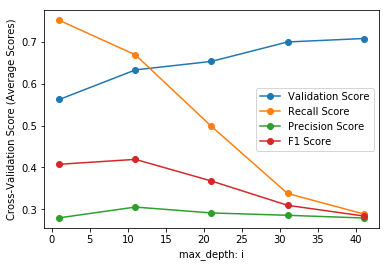

In [36]:
import numpy as np
from sklearn.tree import DecisionTreeClassifier
    
validation_score_list = []
recall_list = []
precision_list = []
f1score_list = []

sample_range = np.arange(1,50,10)

    
for i in sample_range:
    # Lets plot out different parameters with 5-fold cross validation


    # Instantiate
    my_tree = DecisionTreeClassifier(max_depth = i, class_weight = 'balanced')

    validation_score = np.mean(cross_val_score(my_tree, X_train_scaled, y_train, cv = 5))
    validation_score_list.append(validation_score)
    
    # Fit
    my_tree.fit(X_train_scaled, y_train)

    # predict
    pred_train = my_tree.predict(X_train_scaled)
    pred_test = my_tree.predict(X_test_scaled)
    
    recall_list.append(recall_score(y_test, pred_test))
    precision_list.append(precision_score(y_test, pred_test))
    f1score_list.append(f1_score(y_test, pred_test))


    
%matplotlib inline
plt.plot(sample_range, validation_score_list,label="Validation Score",marker='o')
plt.plot(sample_range, recall_list,label="Recall Score",marker='o')
plt.plot(sample_range, precision_list,label="Precision Score",marker='o')
plt.plot(sample_range, f1score_list,label="F1 Score",marker='o')
plt.legend()
plt.xlabel('max_depth: i')
plt.ylabel('Cross-Validation Score (Average Scores)')
plt.show();
    
    
    
    

In [ ]:
# Instantiate
    my_tree = DecisionTreeClassifier(max_depth = i, class_weight = 'balanced')

    # Fit
    my_tree.fit(X_train_scaled, y_train)

    # predict
    pred_train = my_tree.predict(X_train_scaled)
    pred_test = my_tree.predict(X_test_scaled)

    # Score
    Train_score = my_tree.score(X_train_scaled, y_train)
    Accuracy = my_tree.score(X_test_scaled, y_test)
    recall = recall_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test)
    f1score = f1_score(y_test, pred_test)
    cmat = confusion_matrix(y_test, pred_test)
    
    
    print('C =', i)
    print('Accuracy =', Accuracy)
    print('Recall =', recall)
    print('Precision =', precision)
    print('f1 score =', f1score)
    print('Confusion matrix:\n', cmat)
    print('\n')
    




## Random Forest

ValueError: x and y must have same first dimension, but have shapes (6,) and (15,)

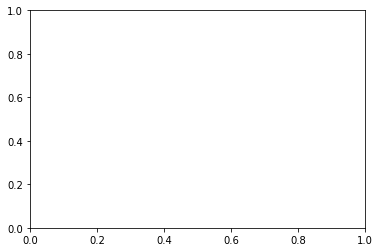

In [47]:
from sklearn.ensemble import RandomForestClassifier
sample_range = np.arange(1,60,10) 
validation_score_list_new = []
for i in sample_range:
    my_random_forest = RandomForestClassifier(n_estimators=i, class_weight = 'balanced')
    validation_score = np.mean(cross_val_score(my_random_forest, X_train_scaled, y_train, cv = 5))
    validation_score_list.append(validation_score)
    
    # Fit
    my_random_forest.fit(X_train_scaled, y_train)

    # predict
    pred_train = my_random_forest.predict(X_train_scaled)
    pred_test = my_random_forest.predict(X_test_scaled)
    
    recall_list.append(recall_score(y_test, pred_test))
    precision_list.append(precision_score(y_test, pred_test))
    f1score_list.append(f1_score(y_test, pred_test))


    
%matplotlib inline
plt.plot(sample_range, validation_score_list,label="Validation Score",marker='o')
plt.plot(sample_range, recall_list,label="Recall Score",marker='o')
plt.plot(sample_range, precision_list,label="Precision Score",marker='o')
plt.plot(sample_range, f1score_list,label="F1 Score",marker='o')
plt.legend()
plt.xlabel('max_depth: i')
plt.ylabel('Cross-Validation Score (Average Scores)')
plt.show();
    

    



In [ ]:
# Score
    Train_score = my_random_forest.score(X_train_scaled, y_train)
    Accuracy = my_random_forest.score(X_test_scaled, y_test)
    recall = recall_score(y_test, pred_test)
    precision = precision_score(y_test, pred_test)
    f1score = f1_score(y_test, pred_test)
    cmat = confusion_matrix(y_test, pred_test)
    
    
    print('n_estimators =', i)
    print('Accuracy =', Accuracy)
    print('Recall =', recall)
    print('Precision =', precision)
    print('f1 score =', f1score)
    print('Confusion matrix:\n', cmat)
    print('\n')
 

Both random forest and decision trees give lower f1 scores that logistical regressions. I decided to go with a regularization of 0.01 as it gives me the highest f1 scores but also a high accuracy. I used class weights as balanced to account for class imbalance.

In [ ]:
# check for value counts of y labels to determine data class imbalance
import numpy as np
np.unique(y_test, return_counts=True)

### Final Model

In [51]:
import numpy as np
from sklearn import metrics
# Instantiate using balanced class weights to account for class-imbalance
LR_model = LogisticRegression(C=0.000001, class_weight = 'balanced')
# Fit
LR_model.fit(X_train_scaled, y_train)

# predict
pred_train = LR_model.predict(X_train_scaled)
pred_test = LR_model.predict(X_test_scaled)

# Score
Train_score = LR_model.score(X_train_scaled, y_train)
Accuracy = LR_model.score(X_test_scaled, y_test)
recall = recall_score(y_test, pred_test)
precision = precision_score(y_test, pred_test)
f1score = f1_score(y_test, pred_test)
cmat = confusion_matrix(y_test, pred_test)


print('Accuracy =', Accuracy)
print('Recall =', recall)
print('Precision =', precision)
print('f1 score =', f1score)
print('Confusion matrix:\n', cmat)
print('\n')


    

Accuracy = 0.6115763810678534
Recall = 0.7203709975770524
Precision = 0.303045248546424
f1 score = 0.42662017303961086
Confusion matrix:
 [[178746 127181]
 [ 21466  55300]]




In [104]:
# Calculate Probability for ROC curve
pred_test_proba = LR_model.predict_proba(X_test_scaled)[:,1]


In [70]:
pred_test_proba.shape

(382693,)

In [71]:
pred_test.shape

(382693,)

In [72]:
y_test.shape

(382693,)

### Challenges and improvements

- While I tried SMOTE in some previous iterations (not doumented here) I didn't test random forest and decision trees with class_weights given time constraints. I would like to see the difference in results if the model has a similar function.

- Add more features into the model to see if the f1 score can be boosted overall across different types of models. 

  

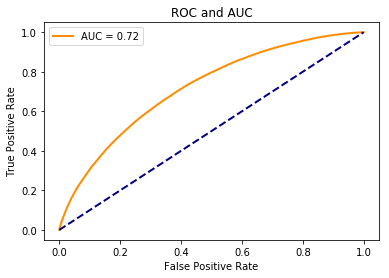

AUC score: 0.717


In [73]:
# model evaluation
from sklearn.metrics import roc_curve, auc    

fpr, tpr, _ = roc_curve(y_test, pred_test_proba)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='AUC = %0.2f' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC and AUC')
plt.legend(loc="best")
plt.show()
print("AUC score: %3.3f" % roc_auc)

In [ ]:
columns = (list(X_train))

In [ ]:
a = (LR_model.coef_)


In [ ]:
# print out column names as columns and coefficients as values
col3= df = pd.DataFrame(a,columns=columns)
col3.head()

In [ ]:
#export to csv
col3.to_csv('C:/Users/Farhan/Documents/Capstone/coefficients.csv')